# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

signnames = []
with open("signnames.csv", 'r') as f:
    next(f)
    reader = csv.reader(f)
    signnames = list(reader)
n_classes = len(signnames)

training_file = "./train.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

### Preprocess Data

In [2]:
from sklearn import cross_validation
X_train, X_test = [], []
y_train, y_test = [], test['labels']

for i, img in enumerate(train['features']):
    img = cv2.resize(img,(48, 48), interpolation = cv2.INTER_CUBIC)
    X_train.append(img)
    y_train.append(train['labels'][i])
    # Adaptive Histogram (CLAHE)
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l, a, b = cv2.split(imgLab)
    l = clahe.apply(l)
    imgLab = cv2.merge((l, a, b))
    imgLab = cv2.cvtColor(imgLab, cv2.COLOR_Lab2RGB)
    X_train.append(imgLab)
    y_train.append(train['labels'][i])
    # Rotate -15
    M = cv2.getRotationMatrix2D((24, 24), -15.0, 1)
    imgL = cv2.warpAffine(img, M, (48, 48))
    X_train.append(imgL)
    y_train.append(train['labels'][i])
    # Rotate 15
    M = cv2.getRotationMatrix2D((24, 24), 15.0, 1)
    imgR = cv2.warpAffine(img, M, (48, 48))
    X_train.append(imgR)
    y_train.append(train['labels'][i])
    
    
for img in test['features']:
    X_test.append(cv2.resize(img,(48, 48), interpolation = cv2.INTER_CUBIC))

X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(X_train, y_train, test_size=0.2, random_state=7)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Number of X_train = ", len(X_train))
print("Number of X_validation = ", len(X_validation))
print("Number of y_train = ", len(y_train))
print("Number of y_validation = ", len(y_validation))

Number of training examples = 125468
Number of testing examples = 12630
Image data shape = (48, 48, 3)
Number of classes = 43
Number of X_train =  125468
Number of X_validation =  31368
Number of y_train =  125468
Number of y_validation =  31368


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

2 Speed limit (50km/h)


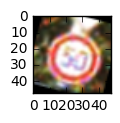

In [4]:
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index], signnames[y_train[index]][1])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 15
BATCH_SIZE = 128

def ConvNet(x):
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 48x48x3. Output = 42x42x100.
    c1_W = tf.Variable(tf.truncated_normal([7, 7, 3, 100], mean=mu, stddev=sigma))
    c1_b = tf.Variable(tf.zeros(100))
    c1 = tf.nn.conv2d(x, c1_W, strides=[1, 1, 1, 1], padding='VALID')
    c1 = tf.nn.bias_add(c1, c1_b)
    c1 = tf.nn.relu(c1)
    
    # Layer 2: Max Pooling. Input = 42x42x100. Output = 21x21x100.
    s2 = tf.nn.max_pool(c1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Layer 3: Convolutional. Input = 21x21x100. Output = 18x18x150.
    c3_W = tf.Variable(tf.truncated_normal([4, 4, 100, 150], mean=mu, stddev=sigma))
    c3_b = tf.Variable(tf.zeros(150))
    c3 = tf.nn.conv2d(s2, c3_W, strides=[1, 1, 1, 1], padding='VALID')
    c3 = tf.nn.bias_add(c3, c3_b)
    c3 = tf.nn.relu(c3)
    
    # Layer 4: Max Pooling. Input = 18x18x150. Output = 9x9x150
    s4 = tf.nn.max_pool(c3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Layer 5: Convolutional. Input = 9x9x150. Output = 6x6x250.
    c5_W = tf.Variable(tf.truncated_normal([4, 4, 150, 250], mean=mu, stddev=sigma))
    c5_b = tf.Variable(tf.zeros(250))
    c5 = tf.nn.conv2d(s4, c5_W, strides=[1, 1, 1, 1], padding='VALID')
    c5 = tf.nn.bias_add(c5, c5_b)
    c5 = tf.nn.relu(c5)
    
    # Layer 6: Max Pooling. Input = 6x6x250. Output = 3x3x250.
    s6 = tf.nn.max_pool(c5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Layer 6: Flatten. Input = 3x3x250. Output = 2250
    s6 = flatten(s6)
    
    # Layer 7: Fully Connected. Input = 2250. Output = 300.
    fc7_W = tf.Variable(tf.truncated_normal([2250, 300], mean=mu, stddev=sigma))
    fc7_b = tf.Variable(tf.zeros(300))
    fc7 = tf.add(tf.matmul(s6, fc7_W), fc7_b)
    fc7 = tf.nn.relu(fc7)
    
    # Layer 8: Fully Connected. Input = 300. Output = 43.
    fc8_W = tf.Variable(tf.truncated_normal([300, 43], mean=mu, stddev=sigma))
    fc8_b = tf.Variable(tf.zeros(43))
    fc8 = tf.add(tf.matmul(fc7, fc8_W), fc8_b)
    
    return fc8

### Features and Labels

In [6]:
x = tf.placeholder(tf.float32, (None, 48, 48, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Training Pipeline

In [7]:
rate = 0.001

logits = ConvNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Model Training

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'convnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.274

EPOCH 2 ...
Validation Accuracy = 0.399

EPOCH 3 ...
Validation Accuracy = 0.513

EPOCH 4 ...
Validation Accuracy = 0.658

EPOCH 5 ...
Validation Accuracy = 0.718

EPOCH 6 ...
Validation Accuracy = 0.781

EPOCH 7 ...
Validation Accuracy = 0.823

EPOCH 8 ...
Validation Accuracy = 0.854

EPOCH 9 ...
Validation Accuracy = 0.902

EPOCH 10 ...
Validation Accuracy = 0.892

EPOCH 11 ...
Validation Accuracy = 0.910

EPOCH 12 ...
Validation Accuracy = 0.937

EPOCH 13 ...
Validation Accuracy = 0.922

EPOCH 14 ...
Validation Accuracy = 0.955

EPOCH 15 ...
Validation Accuracy = 0.963

Model saved


### Model Evaluation

In [10]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph("convnet.meta")
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.947


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I did not preprocess the data. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I generate additional data using 3 methods:
    1. Adaptive histogram
    2. Rotate -15 degree
    3. Rotate 15 degree
Additionally, I resize the images from 32x32 to 48x48
I took the action according to the paper Multi-Column Deep Neural Network for Traffic Sign
Classification (for Adaptive histogram) and Traffic Sign Recognition with Multi-Scale Convolutional Networks (for rotation). 

Finally, I split the training data into 2 parts following 80:20 for cross validation.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I uses the architecture from Multi-Column Deep Neural Network for Traffic Sign
Classification by Ciresan et. al. The following lines briefly describes the layers:

Input: 48x48x3 images

Layer 1: Convolutional layer with 7x7 kernel which output 100 maps of 42x42 neurons

Layer 2: Max-pooling layer with 2x2 kernel and 2 strides which output 100 maps of 21x21 neurons

Layer 3: Convolutional layer with 4x4 kernel which output 150 maps of 18x18 neurons

Layer 4: Max-pooling layer with 2x2 kernel and 2 strides which output 100 maps of 9x9 neurons

Layer 5: Convolutional layer with 4x4 kernel which output 250 maps of 6x6 neurons

Layer 6: Max-pooling layer with 2x2 kernel and 2 strides which output 100 maps of 3x3 neurons

Layer 7: Fully-connected layer outputing 300 neurons

Layer 8: Fully-connected layer outputing 43 neurons/logits

#### Resubmission:
Reformat to show the entire architecture because the previous reviewer misunderstood that I used Lenet5. 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer: Adam-optimizer
Batch size: 128
Epochs: 10
Hyperparameters: mu = 0, sigma = 0.1
Learning rate: 0.001

#### Resubmission:
In the review, the reviewer suggested to look into tuning the number of Epochs. From the result of the cross-validation in my first submission, I used 10 Epoch which ended up with the accuracy around 0.9. However, at 10 Epochs, the model seems to be still learning better. Therefore, I increased the from 10 Epochs to 20 Epochs. 

In the second iteration (after increasing the number of epoch), the results plateau from 15th epoch at 0.960 and then decreased after 19th epoch until 0.935. The accuracy of model evaluation on test data is only 0.9 (slight increase from first iteration at 0.898). I decided to decrease the epoch to 15 epochs, fearing it might overfit the training data. 

The accuracy of third iteration (at 15 epochs) remain at 0.96. However, when tested on test data, the accuracy increases to 0.947 which explain early-stopping helps the model to generalise better by not overfitting the training data too much.



### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I tried Lenet-5 prior to the current architecture. The evaluation result is about 0.8. After changing the architecture, the result improved to above 0.9. I decided to add additional training images after viewing the images. Some of them are darkened, and some of them off-centered. Therefore, I took cue from 2 papers above to generate additional data by using adaptive histogram and rotation. The results improved.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

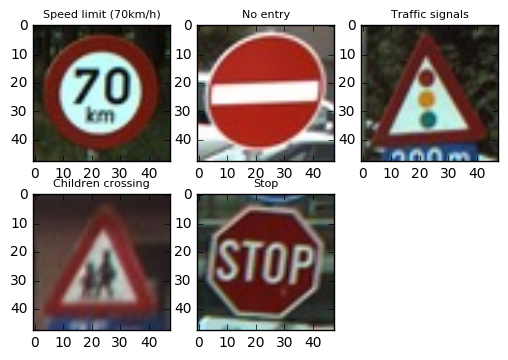

In [11]:
from PIL import Image

# Visualizations will be shown in the notebook.
%matplotlib inline

new_images = []
new_labels = np.array([4, 17, 26, 28, 14])

fig = plt.figure()
for i in range(1, 6): 
    subplot = fig.add_subplot(2,3,i)
    img = cv2.imread("./dataset/{}.png".format(i))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img,(48, 48), interpolation = cv2.INTER_CUBIC)
    subplot.set_title(signnames[new_labels[i-1]][1],fontsize=8)
    subplot.imshow(img)
    new_images.append(img)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [12]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph("convnet.meta")
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    new_pics_classes = sess.run(logits, feed_dict={x: new_images})
    test_accuracy = evaluate(new_images, new_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    top3 = sess.run(tf.nn.top_k(new_pics_classes, k=3, sorted=True))
    
    for i in range(len(top3[0])):
        labels = list(map(lambda x: signnames[x][1], top3[1][i]))
        print("Image {} predicted labels: {} with probabilities: {}".format(i+1, labels, top3[0][i]))

Test Accuracy = 0.800
Image 1 predicted labels: ['Speed limit (100km/h)', 'Roundabout mandatory', 'Speed limit (80km/h)'] with probabilities: [ 77.87373352  76.30887604  73.49340057]
Image 2 predicted labels: ['No entry', 'No passing for vehicles over 3.5 metric tons', 'Stop'] with probabilities: [ 962.11468506  431.13461304  418.85314941]
Image 3 predicted labels: ['Traffic signals', 'Priority road', 'Speed limit (20km/h)'] with probabilities: [ 110.26464844   93.05916595   73.32206726]
Image 4 predicted labels: ['Children crossing', 'Beware of ice/snow', 'Bicycles crossing'] with probabilities: [ 82.21813202  77.32015228  65.69948578]
Image 5 predicted labels: ['Stop', 'No entry', 'No passing for vehicles over 3.5 metric tons'] with probabilities: [ 106.84534454   67.30982971   59.58447266]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The accuracy is 80%. With only 1 minor mistake which the model mistaken 70 as 20 which is incredible narrow because 2 is very similar to 7 in some perspective. 

#### Resubmission:
There is one particular image that is difficult to predict which is Speed limit (70km/h). It predicted as Speed limit (20km/h), only the value of the speed limit differs. There is several factors that influenced this result. It might probably due to the fact that the shape of 7 looks like 2 in some perspective. 

On another attempt after retrain the model, the model still failed to predict the label correctly. It predicted it as Speed limit (100km/h)The second reason can be because there are a total of 8 speed limit signs in the training data, there might not be enough sign for 70km/h which made the prediction for the particular sign more difficult. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

Looking at all the Top 3, the model predicted Image 2 with high confidence whereas the rest are very close. It is astonishing to see the model recognize Image 1 as a speed limit sign just that it wrongly predict the speed limit (70->20). 

#### Resubmission:
Using the tf.nn.top to analyse the prediction failure, I was surprised to see that the model correctly identify the Speed limit 70km/h as a speed limit sign. Although the prediction for the Top 3 are wrong, but all the Top 3 predictions are all speed limit with different value. All 3 predictions have similar probablities, which infers that the model tried to guess the value of the sign (but it failed to capture 70km/h). It might response better if I increase the number of training data for every speed limit sign so that the model can recognize the value of the speed limit better. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.